Installation guides:

https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

https://pytorch.org/get-started/locally/

In [ ]:
!python3 -m pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!python3 -m pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html

In [5]:
!python3 -m pip install littleballoffur

  Using cached littleballoffur-2.2.0.tar.gz (20 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Using cached cmake-3.26.0-py2.py3-none-win_amd64.whl (33.0 MB)
  Using cached Cython-0.29.33-py2.py3-none-any.whl (987 kB)
  Using cached python-louvain-0.16.tar.gz (204 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached networkit-7.1.tar.gz (3.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\lerus\AppData\Local\Temp\pip-install-odfivyci\networkit_773aa4fb1b6044869d11df6e983c2c13\setup.py", line 7, in <module>
          from Cython.Build import cythonize
      ModuleNotFoundError: No module named 'Cython'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\lerus\AppData\Local\Microsoft\WindowsApps\PythonSoftware

In [2]:
import time
import statistics
# import pytorch_geometric.examples.tgn as TGN
from tqdm import tqdm, trange
import os

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear
import logging

from torch_geometric.profile import profileit, get_stats_summary
from torch_geometric.datasets import JODIEDataset, WikiCS
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)
import networkx as nx
import numpy as np

print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using cuda:', torch.cuda.is_available())

11.7
Using cuda: True


## Dataset
Reddit and Wikipedia are bipartite interaction graphs. 

1. In the **Reddit** dataset, users and sub-reddits are nodes, and an interaction occurs when a user writes a post to the sub-reddit.
2. In the **Wikipedia** dataset, users and pages are nodes, and an interaction represents a user editing a page. In both aforementioned datasets, the interactions are represented by text features (of a post or page edit, respectively), and labels represent whether a user is banned. Both interactions and labels are time-stamped.

# Test

threshold 0.006447831184056271


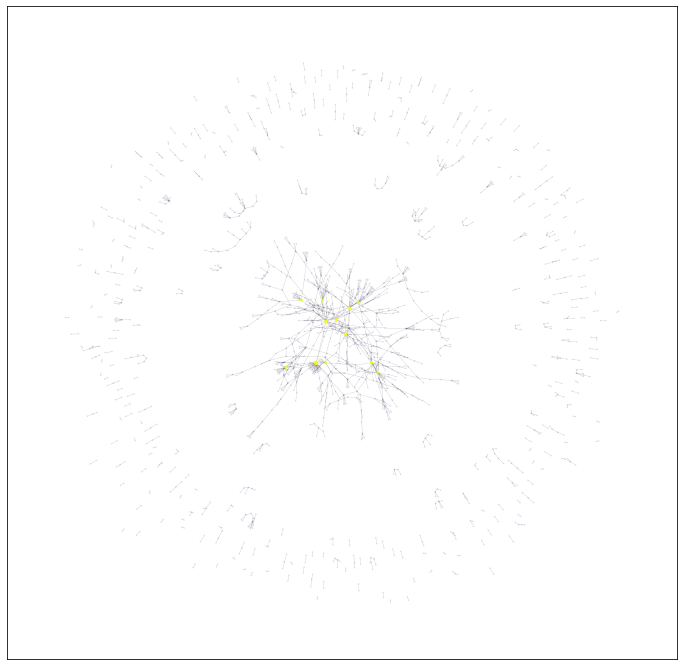

In [103]:
# ## Visualize Graph

# G = nx.from_pandas_edgelist(DATASET[:5000], source=0, target=1, edge_attr=True)
# pos = nx.spring_layout(G, seed=42)
# cent = nx.degree_centrality(G)
# node_size = list(map(lambda x: x * 500, cent.values()))
# cent_array = np.array(list(cent.values()))
# threshold = sorted(cent_array, reverse=True)[10]
# print("threshold", threshold)
# cent_bin = np.where(cent_array >= threshold, 1, 0.1)
# plt.figure(figsize=(12, 12))
# nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
#                                cmap=plt.cm.plasma,
#                                node_color=cent_bin,
#                                nodelist=list(cent.keys()),
#                                alpha=cent_bin)
# edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
# plt.show()

In [2]:
import pandas as pd
from torch_geometric.data import TemporalData
import torch


class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

def select_rows_from_df(df: pd.DataFrame, rows: int = None):
    assert not df.empty, "The specified DataFrame is empty!"
    if (rows == None): rows = len(df) -1
    assert rows <= len(df)   
        
    src = torch.from_numpy(df.iloc[0:rows, 0].values).to(torch.long)
    dst = torch.from_numpy(df.iloc[0:rows, 1].values).to(torch.long)
    print(src.max())
    dst += int(src.max()) + 1
    t = torch.from_numpy(df.iloc[0:rows, 2].values).to(torch.long)
    y = torch.from_numpy(df.iloc[0:rows, 3].values).to(torch.long)
    msg = torch.from_numpy(df.iloc[0:rows, 4:].values).to(torch.float)

    data = TemporalData(src=src, dst=dst, t=t, msg=msg, y=y)

    return data

DATA_DIR = 'wikipedia.csv'
DATASET = pd.read_csv(DATA_DIR, skiprows=1, header=None)

# path = os.path.join("dataset")
# dataset = JODIEDataset(path, name='wikipedia')
# data = dataset[0]

# print(f'Dataset: {dataset}:')
# print(f'Number of graphs: {len(dataset)}')
# print(f'Number of features: {data.num_features}')
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')

C:\Users\lerus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from littleballoffur import DiffusionSampler

G = nx.from_pandas_edgelist(DATASET, source = 0, target = 1, edge_attr=True)
model = DissusionSampler(number_of_nodes = 100, seed = 42)
sub_graph = model.sample(G)

ModuleNotFoundError: No module named 'littleballoffur'

In [27]:
G = nx.from_pandas_edgelist(DATASET, source = 0, target = 1, edge_attr=True)
single_edge_nodes = [node for (node, edge_amount) in G.degree() if edge_amount == 1]
G_sub = G.subgraph(single_edge_nodes)
SINGLE_EDGE_DATASET = nx.to_pandas_edgelist(G_sub)

data = select_rows_from_df(SINGLE_EDGE_DATASET)
print(f'Number of features: {data.num_features}')
print(f'Number of nodes: {data.num_nodes}') # wrong evaluation
print(f'Number of edges: {data.num_edges}')

AssertionError: The specified DataFrame is empty!

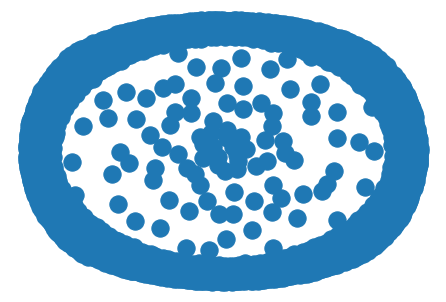

In [34]:
nx.draw(G_sub)

In [35]:
nx.to_pandas_edgelist(G_sub, source="source", target="target", nodelist=single_edge_nodes)

,source,target


In [25]:
G.degree()

DegreeView({0: 28, 1: 3, 2: 7, 3: 4, 4: 13, 5: 9, 6: 2, 7: 24, 8: 42, 9: 13, 10: 47, 11: 10, 12: 22, 13: 13, 14: 73, 15: 27, 16: 64, 17: 224, 18: 22, 19: 48, 20: 55, 21: 21, 22: 139, 23: 97, 24: 30, 25: 38, 26: 37, 27: 12, 28: 8, 29: 19, 30: 48, 31: 5, 32: 4, 33: 138, 34: 58, 35: 39, 36: 41, 37: 41, 38: 19, 39: 49, 40: 155, 41: 38, 42: 23, 43: 21, 44: 20, 45: 46, 46: 56, 47: 21, 48: 28, 49: 19, 50: 40, 51: 48, 52: 9, 53: 11, 54: 4, 55: 51, 56: 52, 57: 26, 58: 61, 59: 24, 60: 11, 61: 19, 62: 24, 63: 47, 64: 13, 65: 51, 66: 28, 67: 37, 68: 434, 69: 12, 70: 36, 71: 27, 72: 36, 73: 93, 74: 43, 75: 38, 76: 10, 77: 32, 78: 13, 79: 18, 80: 20, 81: 24, 82: 7, 83: 12, 84: 32, 85: 35, 86: 18, 87: 60, 88: 14, 89: 36, 90: 11, 91: 60, 92: 19, 93: 28, 94: 10, 95: 15, 96: 25, 97: 18, 98: 26, 99: 6, 100: 19, 101: 23, 102: 4, 103: 27, 104: 43, 105: 12, 106: 29, 107: 16, 108: 30, 109: 37, 110: 9, 111: 19, 112: 113, 113: 11, 114: 46, 115: 24, 116: 57, 117: 16, 118: 8, 119: 69, 120: 131, 121: 26, 122: 52,

In [10]:
src = torch.from_numpy(SINGLE_EDGE_DATASET.iloc[0:len(SINGLE_EDGE_DATASET) - 1, 0].values).to(torch.long)

In [18]:
G.subgraph(single_edge_nodes)

In [12]:
src

tensor([], dtype=torch.int64)

In [163]:
data = data.to(device) 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [162]:
import numpy as np

ITERATIONS = 5
EPOCHS = 51


for sample_size in range(1, data.num_edges+1, int(data.num_edges/100)): # 100 is the amount of points

    sample_data = data.index_select([i for i in range(0, sample_size)]) 
    NUMBER_OF_NODES = sample_size * 2 # as we select each row -> unique pair of nodes

    # data = sample_data
    sample_data = sample_data.to(device)

    # Ensure to only sample actual destination nodes as negatives.
    min_dst_idx, max_dst_idx = int(sample_data.dst.min()), int(sample_data.dst.max())
    train_data, val_data, test_data = sample_data.train_val_test_split(
        val_ratio=0.15, test_ratio=0.15)
    train_loader = TemporalDataLoader(train_data, batch_size=200)
    val_loader = TemporalDataLoader(val_data, batch_size=200)
    test_loader = TemporalDataLoader(test_data, batch_size=200)
    neighbor_loader = LastNeighborLoader(NUMBER_OF_NODES, size=10, device=device)

    memory_dim = time_dim = embedding_dim = 100
    
    memory = TGNMemory(
        NUMBER_OF_NODES,
        sample_data.msg.size(-1),
        memory_dim,
        time_dim,
        message_module=IdentityMessage(sample_data.msg.size(-1), memory_dim, time_dim),
        aggregator_module=LastAggregator(),
    ).to(device)
    gnn = GraphAttentionEmbedding(
        in_channels=memory_dim,
        out_channels=embedding_dim,
        msg_dim=sample_data.msg.size(-1),
        time_enc=memory.time_enc,
    ).to(device)
    link_pred = LinkPredictor(in_channels=embedding_dim).to(device)
    optimizer = torch.optim.Adam(
        set(memory.parameters()) | set(gnn.parameters())
        | set(link_pred.parameters()), lr=0.0001)
    criterion = torch.nn.BCEWithLogitsLoss()
    # Helper vector to map global node indices to local ones.
    assoc = torch.empty(NUMBER_OF_NODES, dtype=torch.long, device=device)
    def train():
        memory.train()
        gnn.train()
        link_pred.train()
        memory.reset_state()  # Start with a fresh memory.
        neighbor_loader.reset_state()  # Start with an empty graph.
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

            # Sample negative destination nodes.
            neg_dst = torch.randint(min_dst_idx, max_dst_idx + 1, (src.size(0), ),
                                    dtype=torch.long, device=device)

            n_id = torch.cat([src, pos_dst, neg_dst]).unique()
            n_id, edge_index, e_id = neighbor_loader(n_id)
            assoc[n_id] = torch.arange(n_id.size(0), device=device)

            # Get updated memory of all nodes involved in the computation.
            z, last_update = memory(n_id)
            z = gnn(z, last_update, edge_index, sample_data.t[e_id].to(device),
                    sample_data.msg[e_id].to(device))

            pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])
            neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]])

            loss = criterion(pos_out, torch.ones_like(pos_out))
            loss += criterion(neg_out, torch.zeros_like(neg_out))

            # Update memory and neighbor loader with ground-truth state.
            memory.update_state(src, pos_dst, t, msg)
            neighbor_loader.insert(src, pos_dst)

            loss.backward()
            optimizer.step()
            memory.detach()
            total_loss += float(loss) * batch.num_events
        return total_loss / train_data.num_events


    @torch.no_grad()
    def test(loader):
        memory.eval()
        gnn.eval()
        link_pred.eval()
        torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.
        aps, aucs = [], []
        for batch in loader:
            batch = batch.to(device)
            src, pos_dst, t, msg = batch.src, batch.dst, batch.t, batch.msg

            neg_dst = torch.randint(min_dst_idx, max_dst_idx + 1, (src.size(0), ),
                                    dtype=torch.long, device=device)

            n_id = torch.cat([src, pos_dst, neg_dst]).unique()
            n_id, edge_index, e_id = neighbor_loader(n_id)
            assoc[n_id] = torch.arange(n_id.size(0), device=device)

            z, last_update = memory(n_id)
            z = gnn(z, last_update, edge_index, sample_data.t[e_id].to(device),
                    sample_data.msg[e_id].to(device))

            pos_out = link_pred(z[assoc[src]], z[assoc[pos_dst]])
            neg_out = link_pred(z[assoc[src]], z[assoc[neg_dst]])

            y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
            y_true = torch.cat(
                [torch.ones(pos_out.size(0)),
                torch.zeros(neg_out.size(0))], dim=0)

            aps.append(average_precision_score(y_true, y_pred))
            aucs.append(roc_auc_score(y_true, y_pred))

            memory.update_state(src, pos_dst, t, msg)
            neighbor_loader.insert(src, pos_dst)

        return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())
        
    timestamps = []
    
    for i in range(ITERATIONS):
        t = trange(EPOCHS, leave=False)
        start = time.process_time()     
        for epoch in t:
            loss = train()
            t.set_description(f"[{i}/{ITERATIONS}] Edges:{sample_size}, Nodes:{NUMBER_OF_NODES}, Epoch: {epoch:02d}, Loss: {loss:.4f}")
            t.refresh()
        
        execution_time = time.process_time() - start
        timestamps.append(execution_time)
        t.close()

    edges = sample_data.num_edges
    avg_train_time = statistics.mean(timestamps)

    with open(f"test-results/{dataset}-train-nodes.csv", "a") as file:
        file.write(f"{NUMBER_OF_NODES},{edges},{avg_train_time}\n")



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

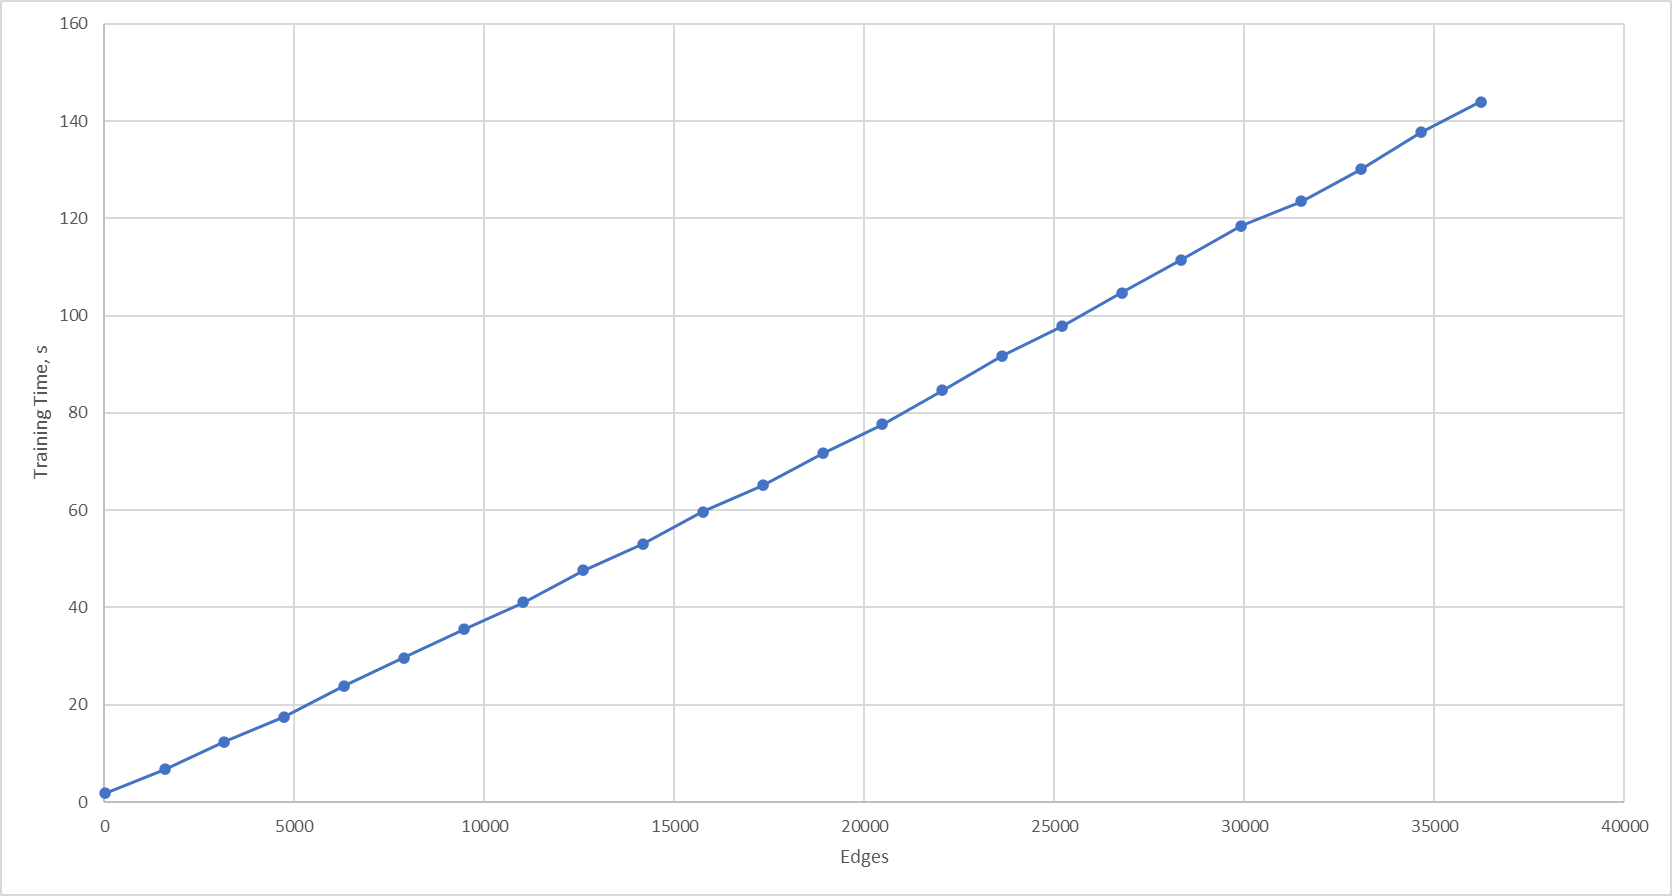